<a href="https://colab.research.google.com/github/zav-iuliia/skillfactory/blob/master/Traffic_Signs_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Signs Recognition 

*In this Python project example, we will build a deep neural network model that can classify traffic signs present in the image into different categories. With this model, we are able to read and understand traffic signs which are a very important task for all autonomous vehicles.*

In [ ]:
!pip uninstall numpy tensorflow-estimator tensorflow -y
!pip install "numpy<1.19.0" "tensorflow-estimator<2.4.0,>=2.3.0" "tensorflow<2.4"

In [9]:
!pip uninstall albumentations -y
!pip install albumentations==0.5

Found existing installation: albumentations 0.4.6
Uninstalling albumentations-0.4.6:
  Successfully uninstalled albumentations-0.4.6
     |████████████████████████████████| 70 kB 3.5 MB/s 
     |████████████████████████████████| 47.6 MB 61.8 MB/s 



## Importing Required Libraries/Импорт необходимых библиотек










In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import Image
import albumentations
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

from matplotlib import style
style.use('fivethirtyeight')

print('Numpy          :', np.__version__)
print('Tensorflow     :', tf.__version__)
print('Keras          :', tf.keras.__version__)
print('albumentations :', albumentations.__version__)

Numpy          : 1.21.4
Tensorflow     : 2.3.4
Keras          : 2.4.0
albumentations : 0.5.0


## Copying and unpacking ZIP with data

In [ ]:
!cp /content/drive/MyDrive/archive/archive.zip /content/
!unzip archive.zip -d archive

In [4]:
PATH = 'archive'

train_path = 'archive/Train'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [5]:
meta = pd.read_csv(f"{PATH}/Meta.csv")
test = pd.read_csv(f"{PATH}/Test.csv")
train = pd.read_csv(f"{PATH}/Train.csv")

Step 1: Explore the dataset

Our ‘train’ folder contains 43 folders each representing a different class. The range of the folder is from 0 to 42. With the help of the OS module, we iterate over all the classes and append images and their respective labels in the data and labels list.

Наша папка "поезд" содержит 43 папки, каждая из которых представляет отдельный класс. Диапазон папки составляет от 0 до 42. С помощью модуля ОС мы перебираем все классы и добавляем изображения и соответствующие им метки в список данных и меток.


In [6]:
#Finding Total Classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [7]:
# Label Overview/Обзор классов
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }


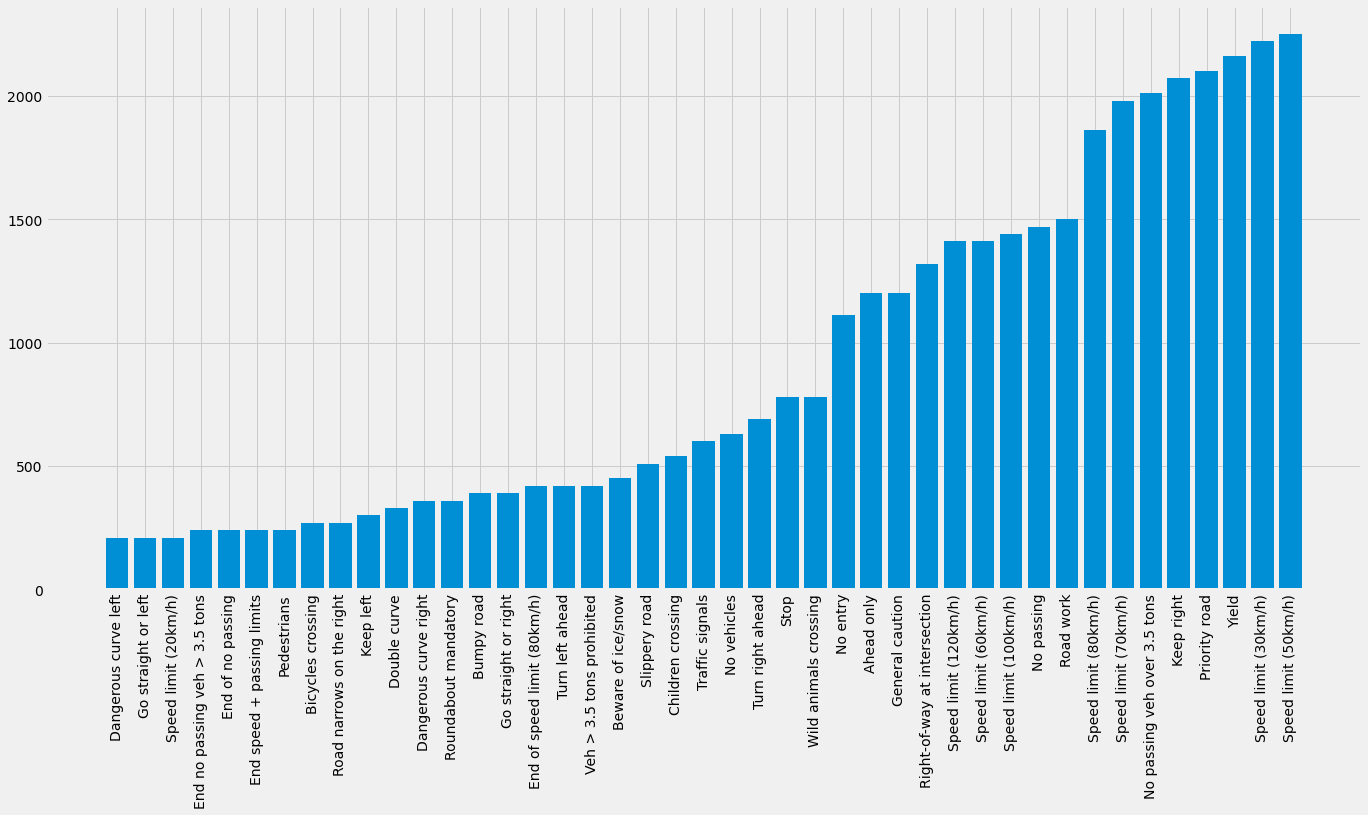

In [8]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class/
# Сортировка набора данных на основе количества изображений в каждом классе
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class/
# Построение графика количества изображений в каждом классе
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

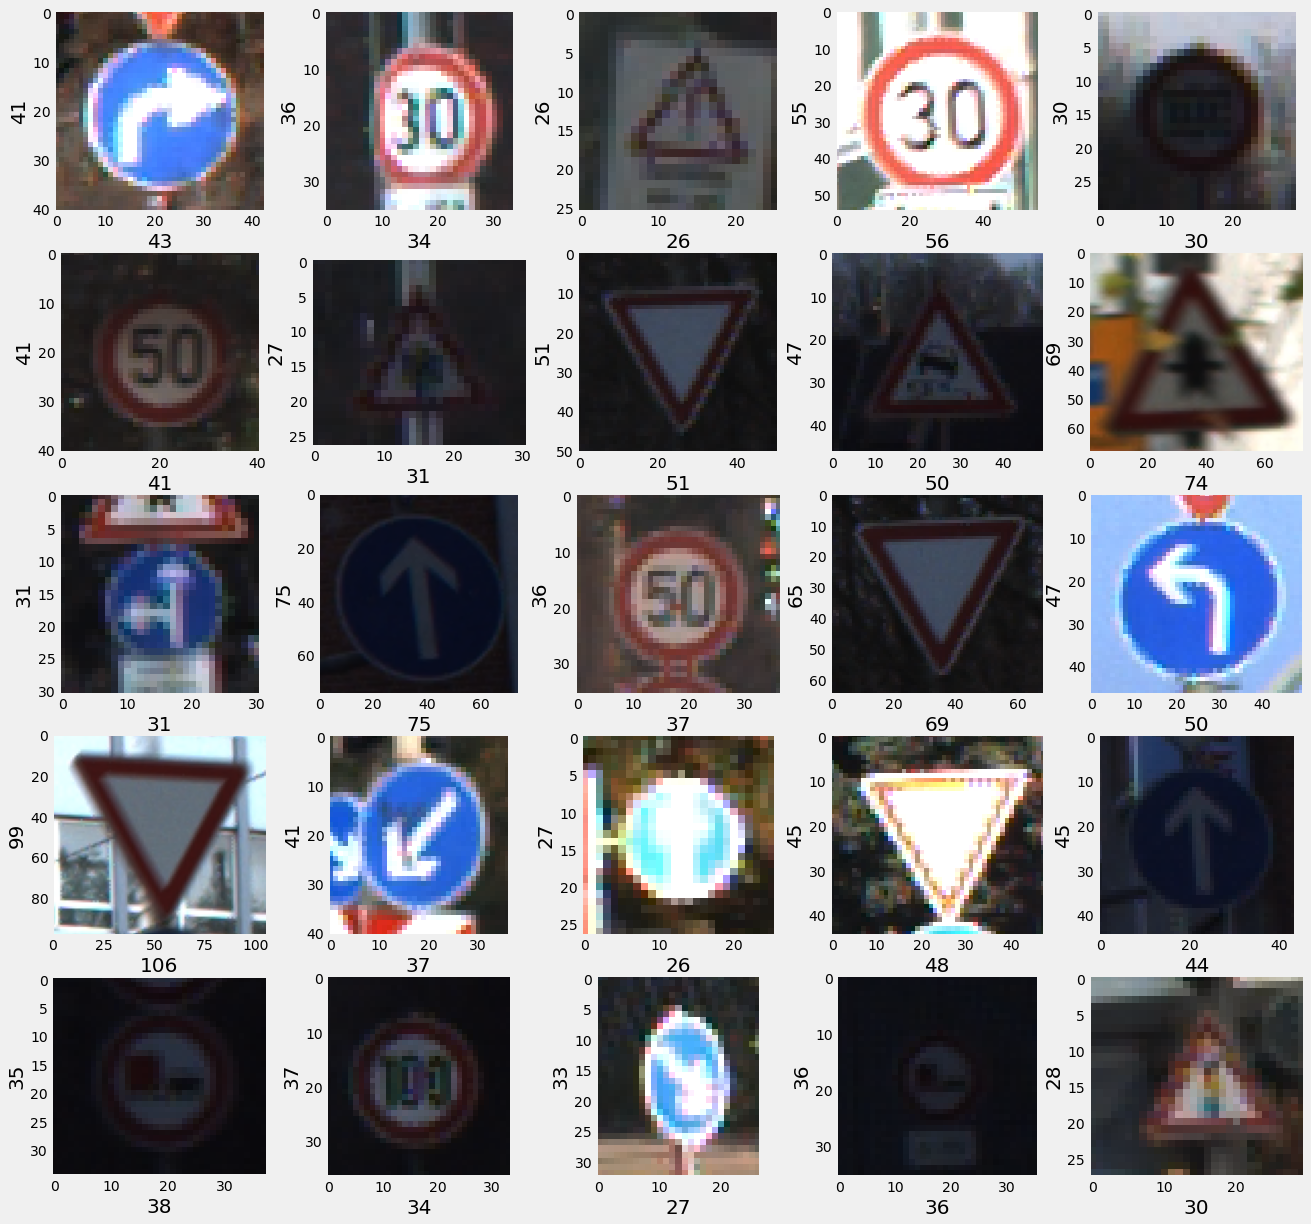

In [9]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(PATH + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(20,20))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = PATH + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image



## Collecting the Training Data

Сбор обучающих данных

In [10]:
image_data = []
image_labels = []

for i in tqdm(range(NUM_CATEGORIES)):
    path = f'{PATH}/Train/{i}'
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(f"{path}/{img}")
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print(f"Error in {img}")

# Changing the list to numpy array/Изменение списка на массив numpy
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

  0%|          | 0/43 [00:00<?, ?it/s]

(39209, 30, 30, 3) (39209,)


## Shuffling the training data/Перетасовка обучающих данных


In [11]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set/Разделение данных 


In [12]:
# 1 The first option is the usual way

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)



X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


### One hot encoding the labels


In [13]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model


In [14]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [15]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Augmenting the data and training the model/Расширение данных и обучение модели


In [16]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 25s 29ms/step - loss: 1.0046 - accuracy: 0.7284 - val_loss: 0.1484 - val_accuracy: 0.9487
Epoch 2/30
858/858 [==============================] - 25s 29ms/step - loss: 0.1751 - accuracy: 0.9483 - val_loss: 0.0589 - val_accuracy: 0.9827
Epoch 3/30
858/858 [==============================] - 25s 29ms/step - loss: 0.1034 - accuracy: 0.9684 - val_loss: 0.0639 - val_accuracy: 0.9787
Epoch 4/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0778 - accuracy: 0.9761 - val_loss: 0.0450 - val_accuracy: 0.9869
Epoch 5/30
858/858 [==============================] - 25s 29ms/step - loss: 0.0663 - accuracy: 0.9792 - val_loss: 0.0243 - val_accuracy: 0.9926
Epoch 6/30
858/858 [==============================] - 23s 27ms/step - loss: 0.0573 - accuracy: 0.9837 - val_loss: 0.0126 - val_accuracy: 0.9969
Epoch 7/30
858/858 [==============================] - 23s 27ms/step - loss: 0.0528 - accuracy: 0.9840 - val_loss: 0.0062 - val_accuracy:

## Evaluating the model


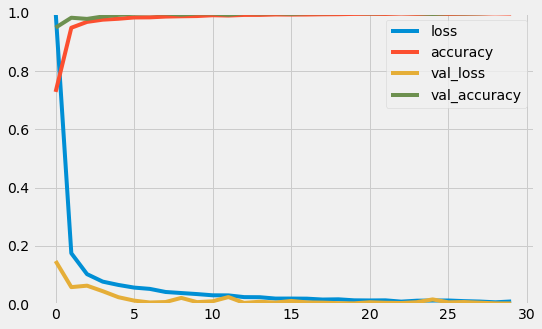

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions/Загрузка тестовых данных и выполнение прогнозов


In [19]:
test = pd.read_csv(PATH + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(PATH + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.47980997624704
